In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering,KMeans,DBSCAN
from scipy.stats import ttest_ind,shapiro,f,mannwhitneyu, ttest_rel,f_oneway,pearsonr, bartlett,chi2_contingency
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan
from sklearn.mixture import GaussianMixture
from scipy.optimize import fmin
import networkx as nx
import seaborn as sns

### **IMPORTATION DES DONNEES** ###

In [340]:
scdf = pd.read_csv("sc.csv", delimiter=',') # diamètre des adipocytes sous cutanés
omdf = pd.read_csv("om.csv", delimiter=',') # diamètre des adipocytes viscéral

variables_métabo = pd.read_csv("NICOLE_Project.csv", sep=";", index_col=1)
df_aa = pd.read_csv("acides aminés.csv", sep=";", index_col=1)

variables_m={
    "BMI" : variables_métabo["BMI"],
    'Adiponectine' : variables_métabo["Adiponectine"],
    "TG" : variables_métabo["Trigly"],
    "leptin" : variables_métabo["Leptine"],
    "HbA1c" : variables_métabo["HbA1C"],
    "HOMA1_IR" : variables_métabo["HOMA1_IR"],
    "HOMA2_IR" : variables_métabo["HOMA2_IR"],
    "HDL" : variables_métabo["HDL"],
    "LDL" : variables_métabo["LDL"],
    "CRP" : variables_métabo["CRP"],
    "FATscore" : variables_métabo["FATscore_scAT"], 
    "fatmass" : variables_métabo["MG_kg"],
    "glutamine" : df_aa["AA-Glutamine3TBDMS plasma"],
    "valine" : df_aa["AA-Valine plasma"],
    "isoleucine" : df_aa["AA-ISO-Leucine plasma"],
    "leucine" : df_aa["AA-Leucine plasma"].where(df_aa["AA-Leucine plasma"]<370,np.nan), 
    "acide glutamique" : df_aa["AA-Glutamic acid plasma"],
    "glycine" : df_aa["AA-Glycine plasma"],
    "serine" : df_aa["AA-Serine plasma"], 
    "méthionine" : df_aa["AA-Methionine plasma"],
    "créatine" : variables_métabo["Creat_P"],
    "IL6"  : variables_métabo["IL6"],
    "QUICKI" :  variables_métabo["QUICKI"],
    "ApoA1" : variables_métabo["ApoA1"],
    "ApoB" : variables_métabo["ApoB"]
    }



In [341]:
# fonction de lissage
def smooth(h,w):
    a = np.zeros(len(h))
    nx = len(h)
    for i in range(nx):
        if i<w :
            a[i] = np.sum(h[0:i+w])/(w+i)

        elif i+w > nx:
            a[i] = np.sum(h[i-w:])/(w + nx - i)
        else:
            a[i] = np.sum(h[i-w:i+w])/(2*w)
    return a

# fonction transformation diamètres en quantité de lipides
def lipids(taille):
    r = taille/2
    Vl = 1.091 * 1e6
    return ((4/3) * np.pi * (r** 3 - 10 **3)) / Vl

# fonction qui calcul à partir d'un diamètre d'adipocyte sa masse totale
def masse (diamètre):
    r=diamètre/2 
    Vl = 1.091*10**6 #µm^3 /nmol
    nl = ((4/3) * np.pi * (r** 3 - 10 **3)) / Vl #qtte lipides totale par patient
    Ml = 900*10**(-9) #g.nmol^-1
    masse = nl * Ml
    return masse 

In [342]:
binning = np.linspace(20,200,50)
# choix de lissage : w = 2

np_frequences_sc=[]
np_frequences_om=[]
for patient in range(1,225) :    
    h1 = scdf[f"patient {patient}"].dropna()    
    h2 = omdf[f"patient {patient}"].dropna()        
    data1,b=np.histogram(h1,bins=binning,density=True)
    data2,b=np.histogram(h2,bins=binning,density=True)
    np_frequences_sc.append(smooth(data1,2))
    np_frequences_om.append(smooth(data2,2))         

frequences_sc = pd.DataFrame(np.array(np_frequences_sc).T)
frequences_om = pd.DataFrame(np.array(np_frequences_om).T)
frequences_sc.columns =[f"patient {i}" for i in range(1,225)]
frequences_om.columns =[f"patient {i}" for i in range(1,225)]

qtte_lpd_sc=lipids(scdf) #quantités lipides par cellule/partient sous-cutané
qtte_lpd_om=lipids(omdf) #quantités lipides par cellule/partient viscéral

sc_ltot=[]
om_ltot=[]
## calcul des quantités de lipides normalisées sur le nombre total de cellules
for patient in range(1,len(scdf.columns)+1) : 
    tot_sc=qtte_lpd_sc[f"patient {patient}"].dropna().sum()/len(qtte_lpd_sc[f"patient {patient}"].dropna())
    sc_ltot.append(tot_sc)

for patient in range(1,len(omdf.columns)+1) : 
    tot_om=qtte_lpd_om[f"patient {patient}"].dropna().sum()/len(qtte_lpd_om[f"patient {patient}"].dropna())
    om_ltot.append(tot_om)

df_lipids_sc = pd.DataFrame(sc_ltot,columns=["qtt_lipides_TA_sc"])
df_lipids_sc.index=[f"patient {patient}" for patient in range (1,225)]
df_lipids_om = pd.DataFrame(om_ltot,columns=["qtt_lipides_TA_om"])
df_lipids_om.index=[f"patient {patient}" for patient in range (1,225)]

### **CALCUL NOMBRE DE CELLULES** ###

In [343]:
analyse = pd.DataFrame(columns=["fatmass totale (g)", "% fatmass totale", "fatmass sc (g)", "% fatmass sc", "Diamètre moyen adipocytes sc", "Masse sc", "Nb cellules sc","fatmass om (g)", "% fatmass om", "Diamètre moyen adipocytes om", "Masse om", "Nb cellules om"],index=[f"patient {patient}" for patient in range (1,225)])

analyse["% fatmass totale"] = variables_métabo["percent_fat_mass"]
analyse["fatmass totale (g)"] = analyse["% fatmass totale"] * variables_métabo["weight"]*10

analyse["fatmass om (g)"] = analyse["fatmass totale (g)"]*0.2
analyse["% fatmass om"] = analyse["% fatmass totale"]*0.2

analyse["fatmass sc (g)"] = analyse["fatmass totale (g)"]*0.8
analyse["% fatmass sc"] = analyse["% fatmass totale"]*0.8

## mettre diamètre moyen dans analyse: 
for patient in range(1,225):
    analyse.loc[f"patient {patient}","Diamètre moyen adipocytes sc"] = scdf[f'patient {patient}'].mean()
    analyse.loc[f"patient {patient}","Diamètre moyen adipocytes om"] = omdf[f'patient {patient}'].mean()


## masse de lipides par cellule (considère que 100% = lipides)
analyse["Masse sc"] = analyse["Diamètre moyen adipocytes sc"].apply(masse)
analyse["Masse om"] = analyse["Diamètre moyen adipocytes om"].apply(masse)

## nombre de cellules 
pd.options.display.float_format = '{:.2e}'.format # afficher les nombres en écriture scientifique
for patient in range (1,225):
    analyse.loc[f"patient {patient}","Nb cellules sc"] = analyse["fatmass sc (g)"][f"patient {patient}"]/analyse["Masse sc"][f"patient {patient}"]
    analyse.loc[f"patient {patient}","Nb cellules om"] = analyse["fatmass om (g)"][f"patient {patient}"]/analyse["Masse om"][f"patient {patient}"]

analyse["nbr cellules total"] = analyse["Nb cellules sc"] + analyse["Nb cellules om"]

analyse["lipids_sc"] = df_lipids_sc
analyse["lipids_om"] = df_lipids_om

#ajout des variables métaboliques à analyse
varrr = pd.DataFrame(variables_m)
analyse = pd.concat([analyse,varrr],axis=1)


In [344]:
Femmes = pd.DataFrame()
Hommes = pd.DataFrame()
Femmes = variables_métabo[variables_métabo["Sexe"]=="F"].index
Hommes = variables_métabo[variables_métabo["Sexe"]=="M"].index

analyseFEMMES = analyse 
analyseHOMMES = analyse 
analyseHOMMES = analyseHOMMES.T
analyseFEMMES = analyseFEMMES.T

for patient in Femmes : 
    analyseHOMMES=analyseHOMMES.drop(columns=patient)

for patient in Hommes : 
    analyseFEMMES=analyseFEMMES.drop(columns=patient)

## un dataframe spécifique aux hommes et aux femmes
analyseHOMMES = analyseHOMMES.T
analyseFEMMES = analyseFEMMES.T

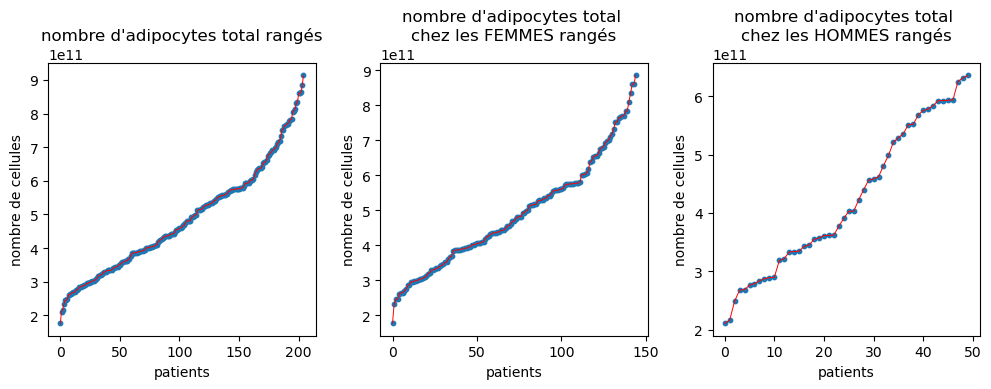

In [345]:
plt.subplots(1,3,figsize=(10,4))

plt.subplot(1,3,1)
c = analyse['nbr cellules total'].dropna()
c = np.sort(c)
c = c[:-10]

plt.plot(c, 'r', linewidth=0.7)
plt.scatter(range(len(c)),c,s=10)
plt.title("nombre d'adipocytes total rangés")
plt.xlabel("patients")
plt.ylabel("nombre de cellules")

plt.subplot(1,3,2)
c = analyseFEMMES['nbr cellules total'].dropna()
c = np.sort(c)
c = c[:-10]

plt.plot(c, 'r', linewidth=0.7)
plt.scatter(range(len(c)),c,s=10)
plt.title("nombre d'adipocytes total \nchez les FEMMES rangés")
plt.xlabel("patients")
plt.ylabel("nombre de cellules")

plt.subplot(1,3,3)
c = analyseHOMMES['nbr cellules total'].dropna()
c = np.sort(c)
c = c[:-10]

plt.plot(c, 'r', linewidth=0.7)
plt.scatter(range(len(c)),c,s=10)
plt.title("nombre d'adipocytes total \nchez les HOMMES rangés")
plt.xlabel("patients")
plt.ylabel("nombre de cellules")

plt.tight_layout()
plt.show()

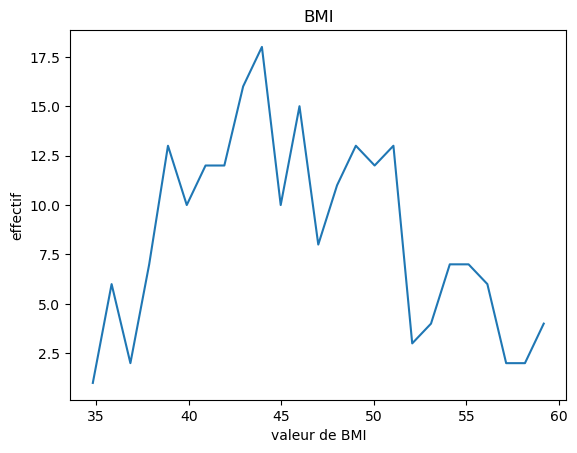

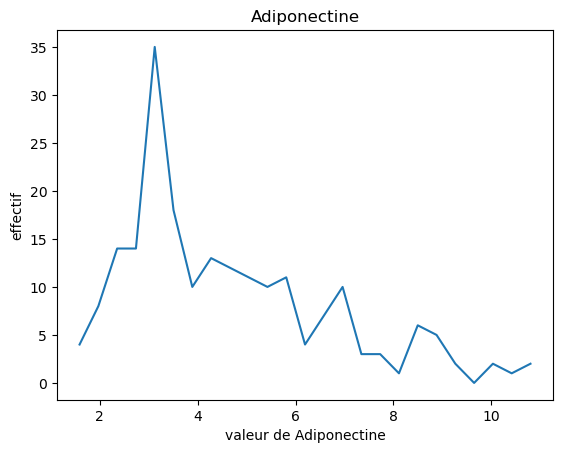

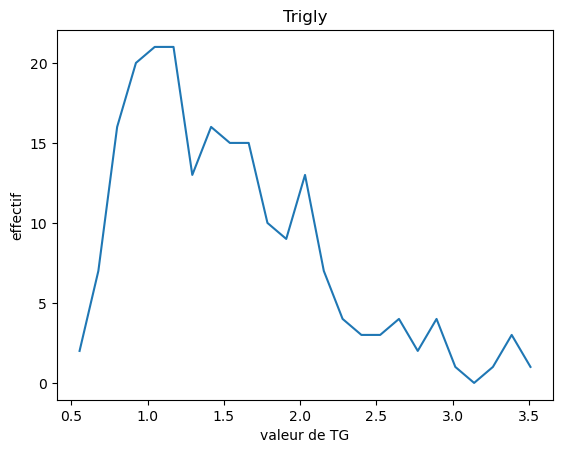

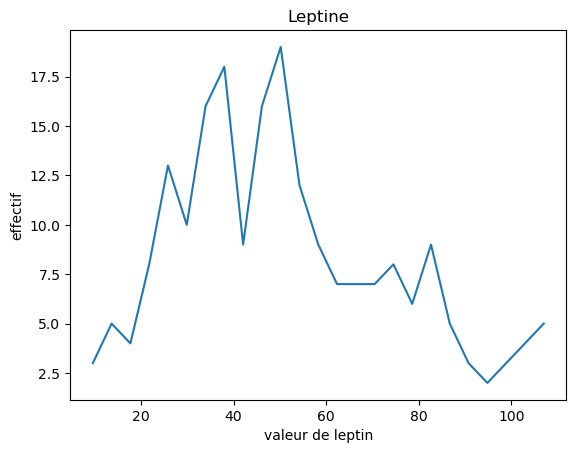

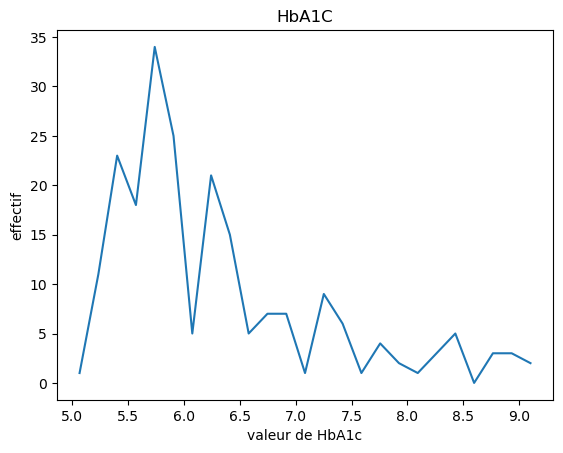

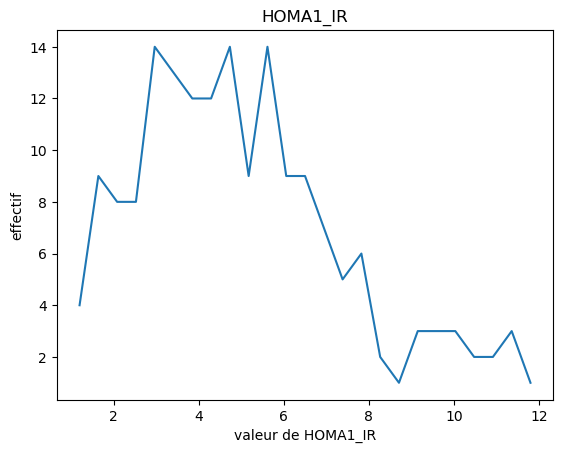

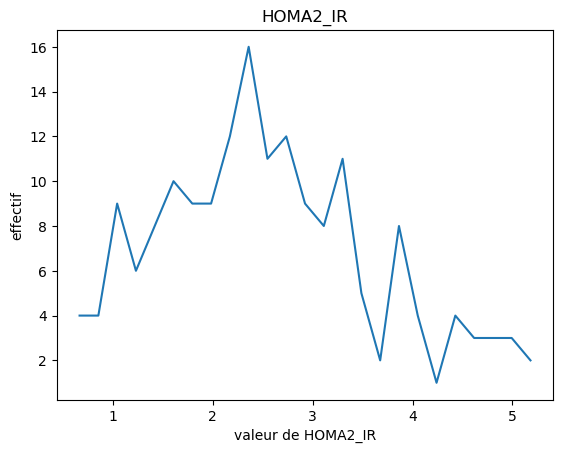

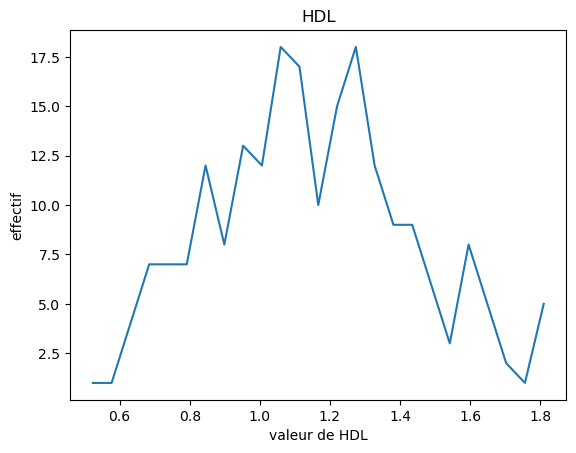

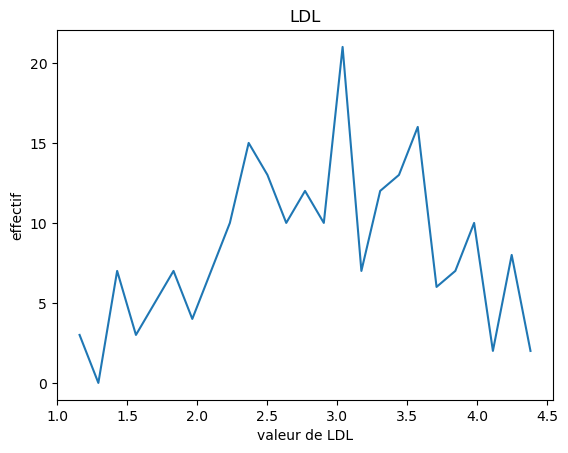

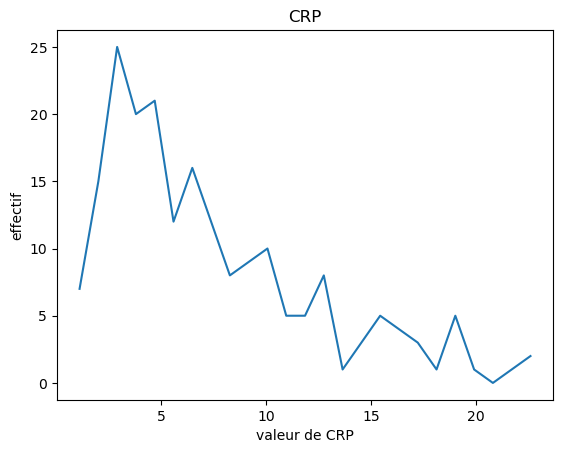

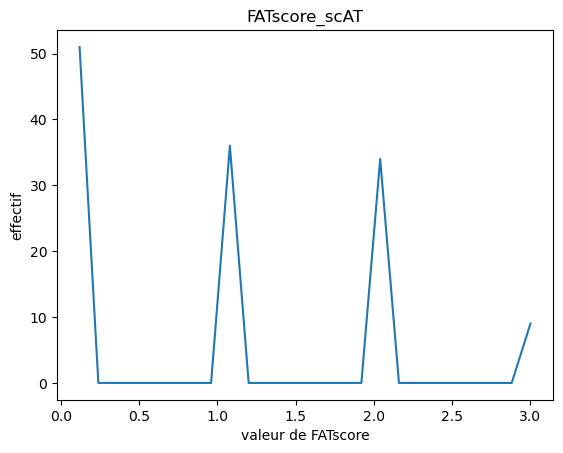

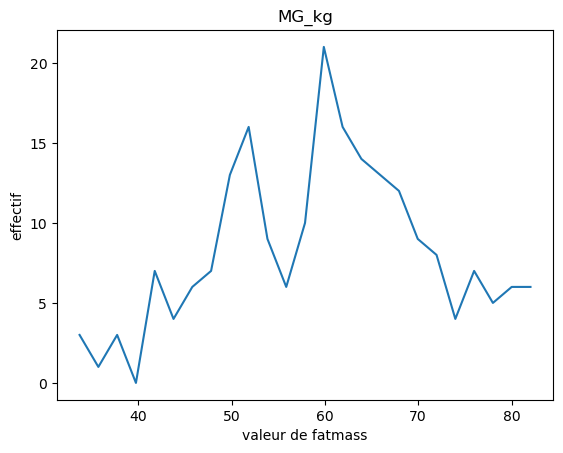

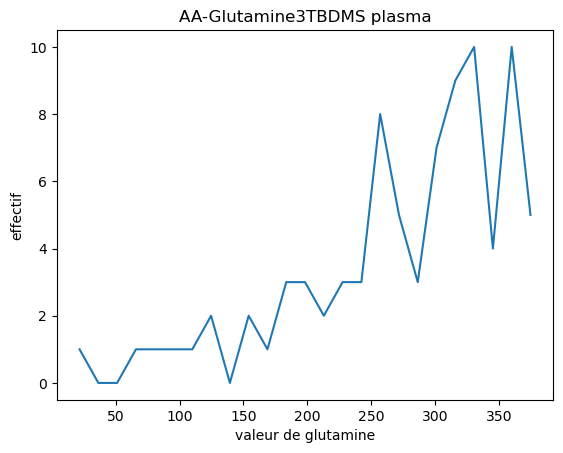

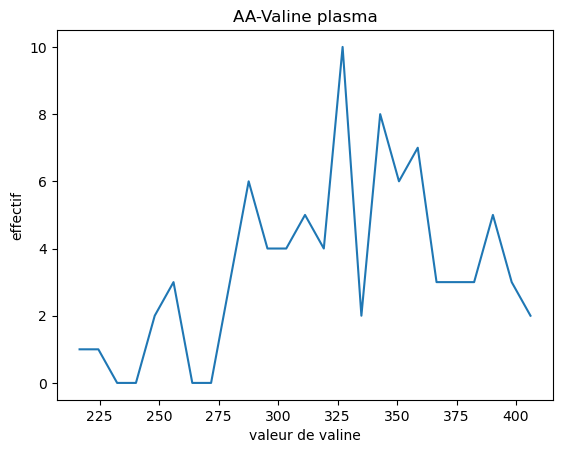

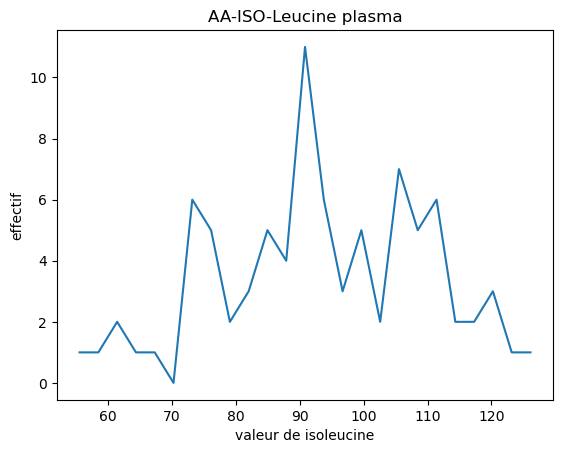

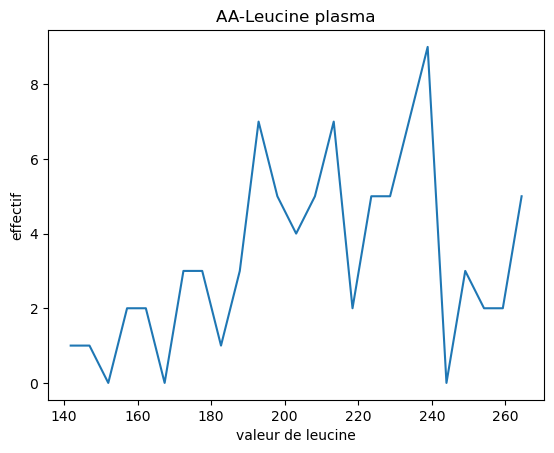

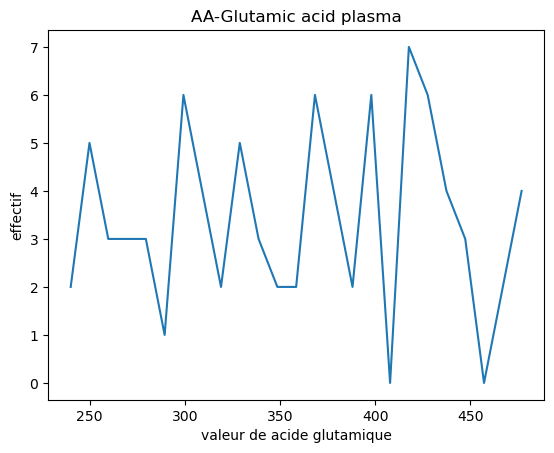

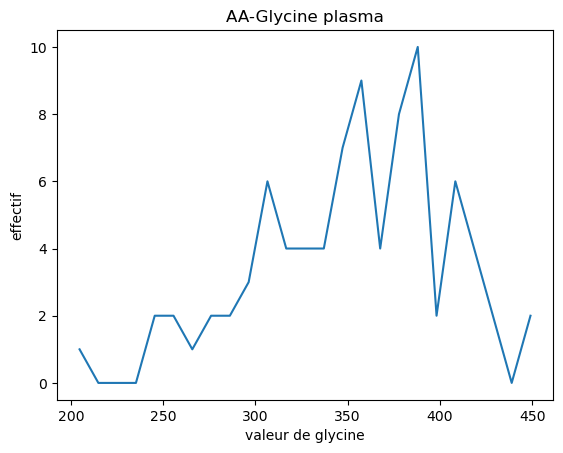

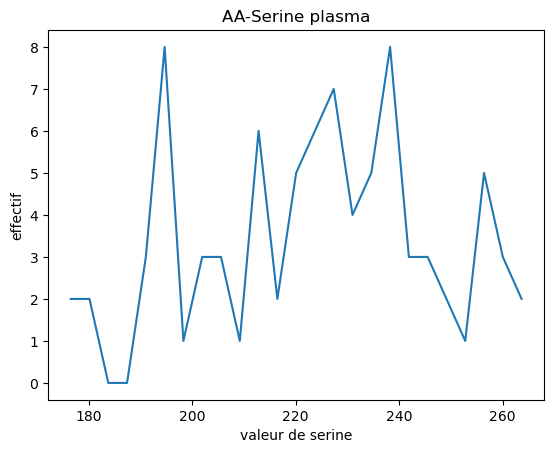

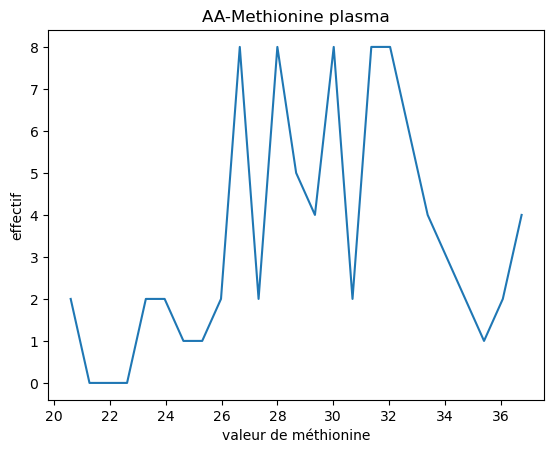

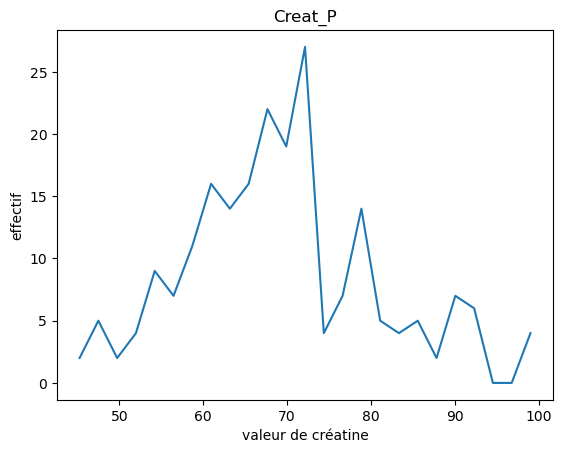

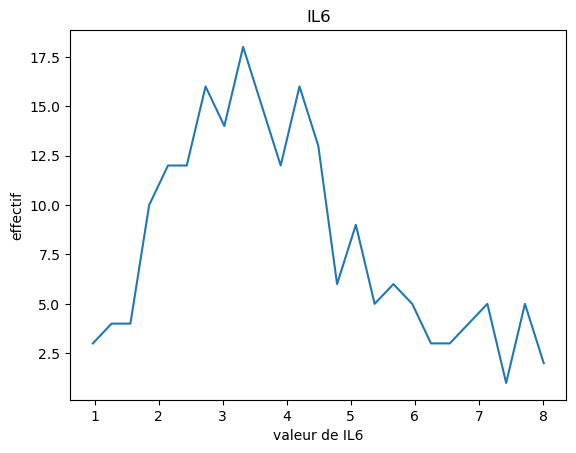

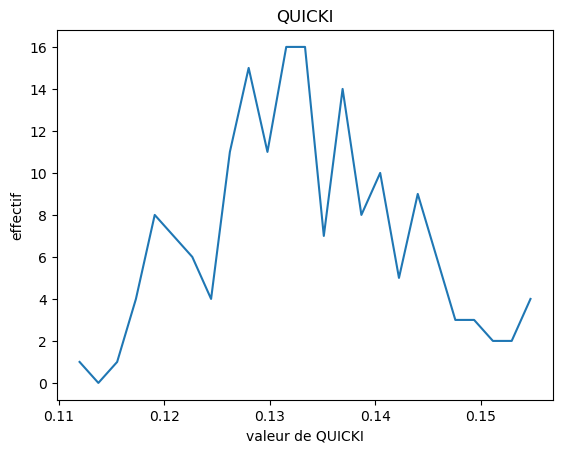

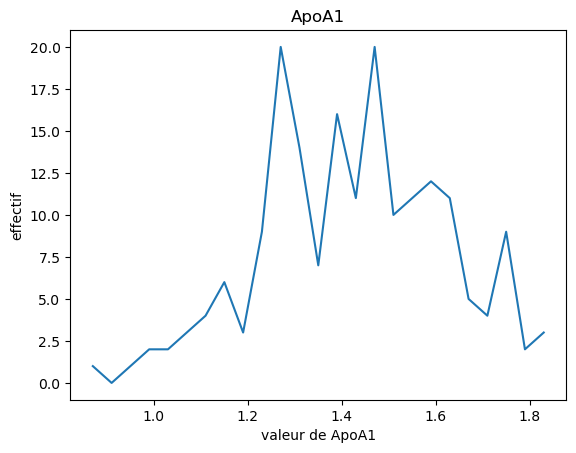

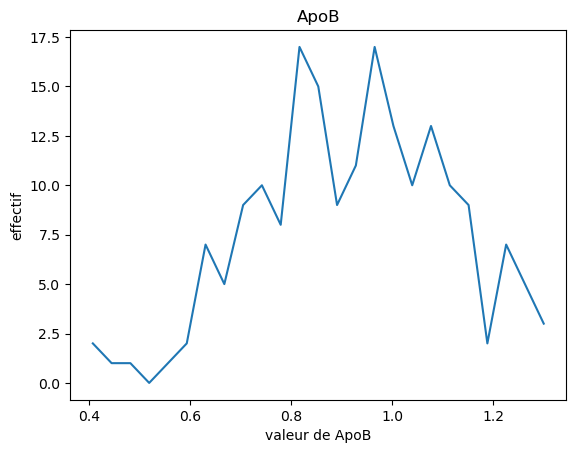

In [346]:
for k,vari in enumerate(variables_m.keys()) : 
    
    plt.figure(k)
    var = variables_m[f'{vari}'].dropna()

    plt.title(f"{var.name}")

    var = np.sort(var)
    var = var[:-10]
    x,y = np.histogram(var,bins=25)
    plt.plot(y[1:],x)
    plt.xlabel(f"valeur de {vari}")
    plt.ylabel("effectif")
    plt.show()

### **MATRICE DE CORRELATION** ###


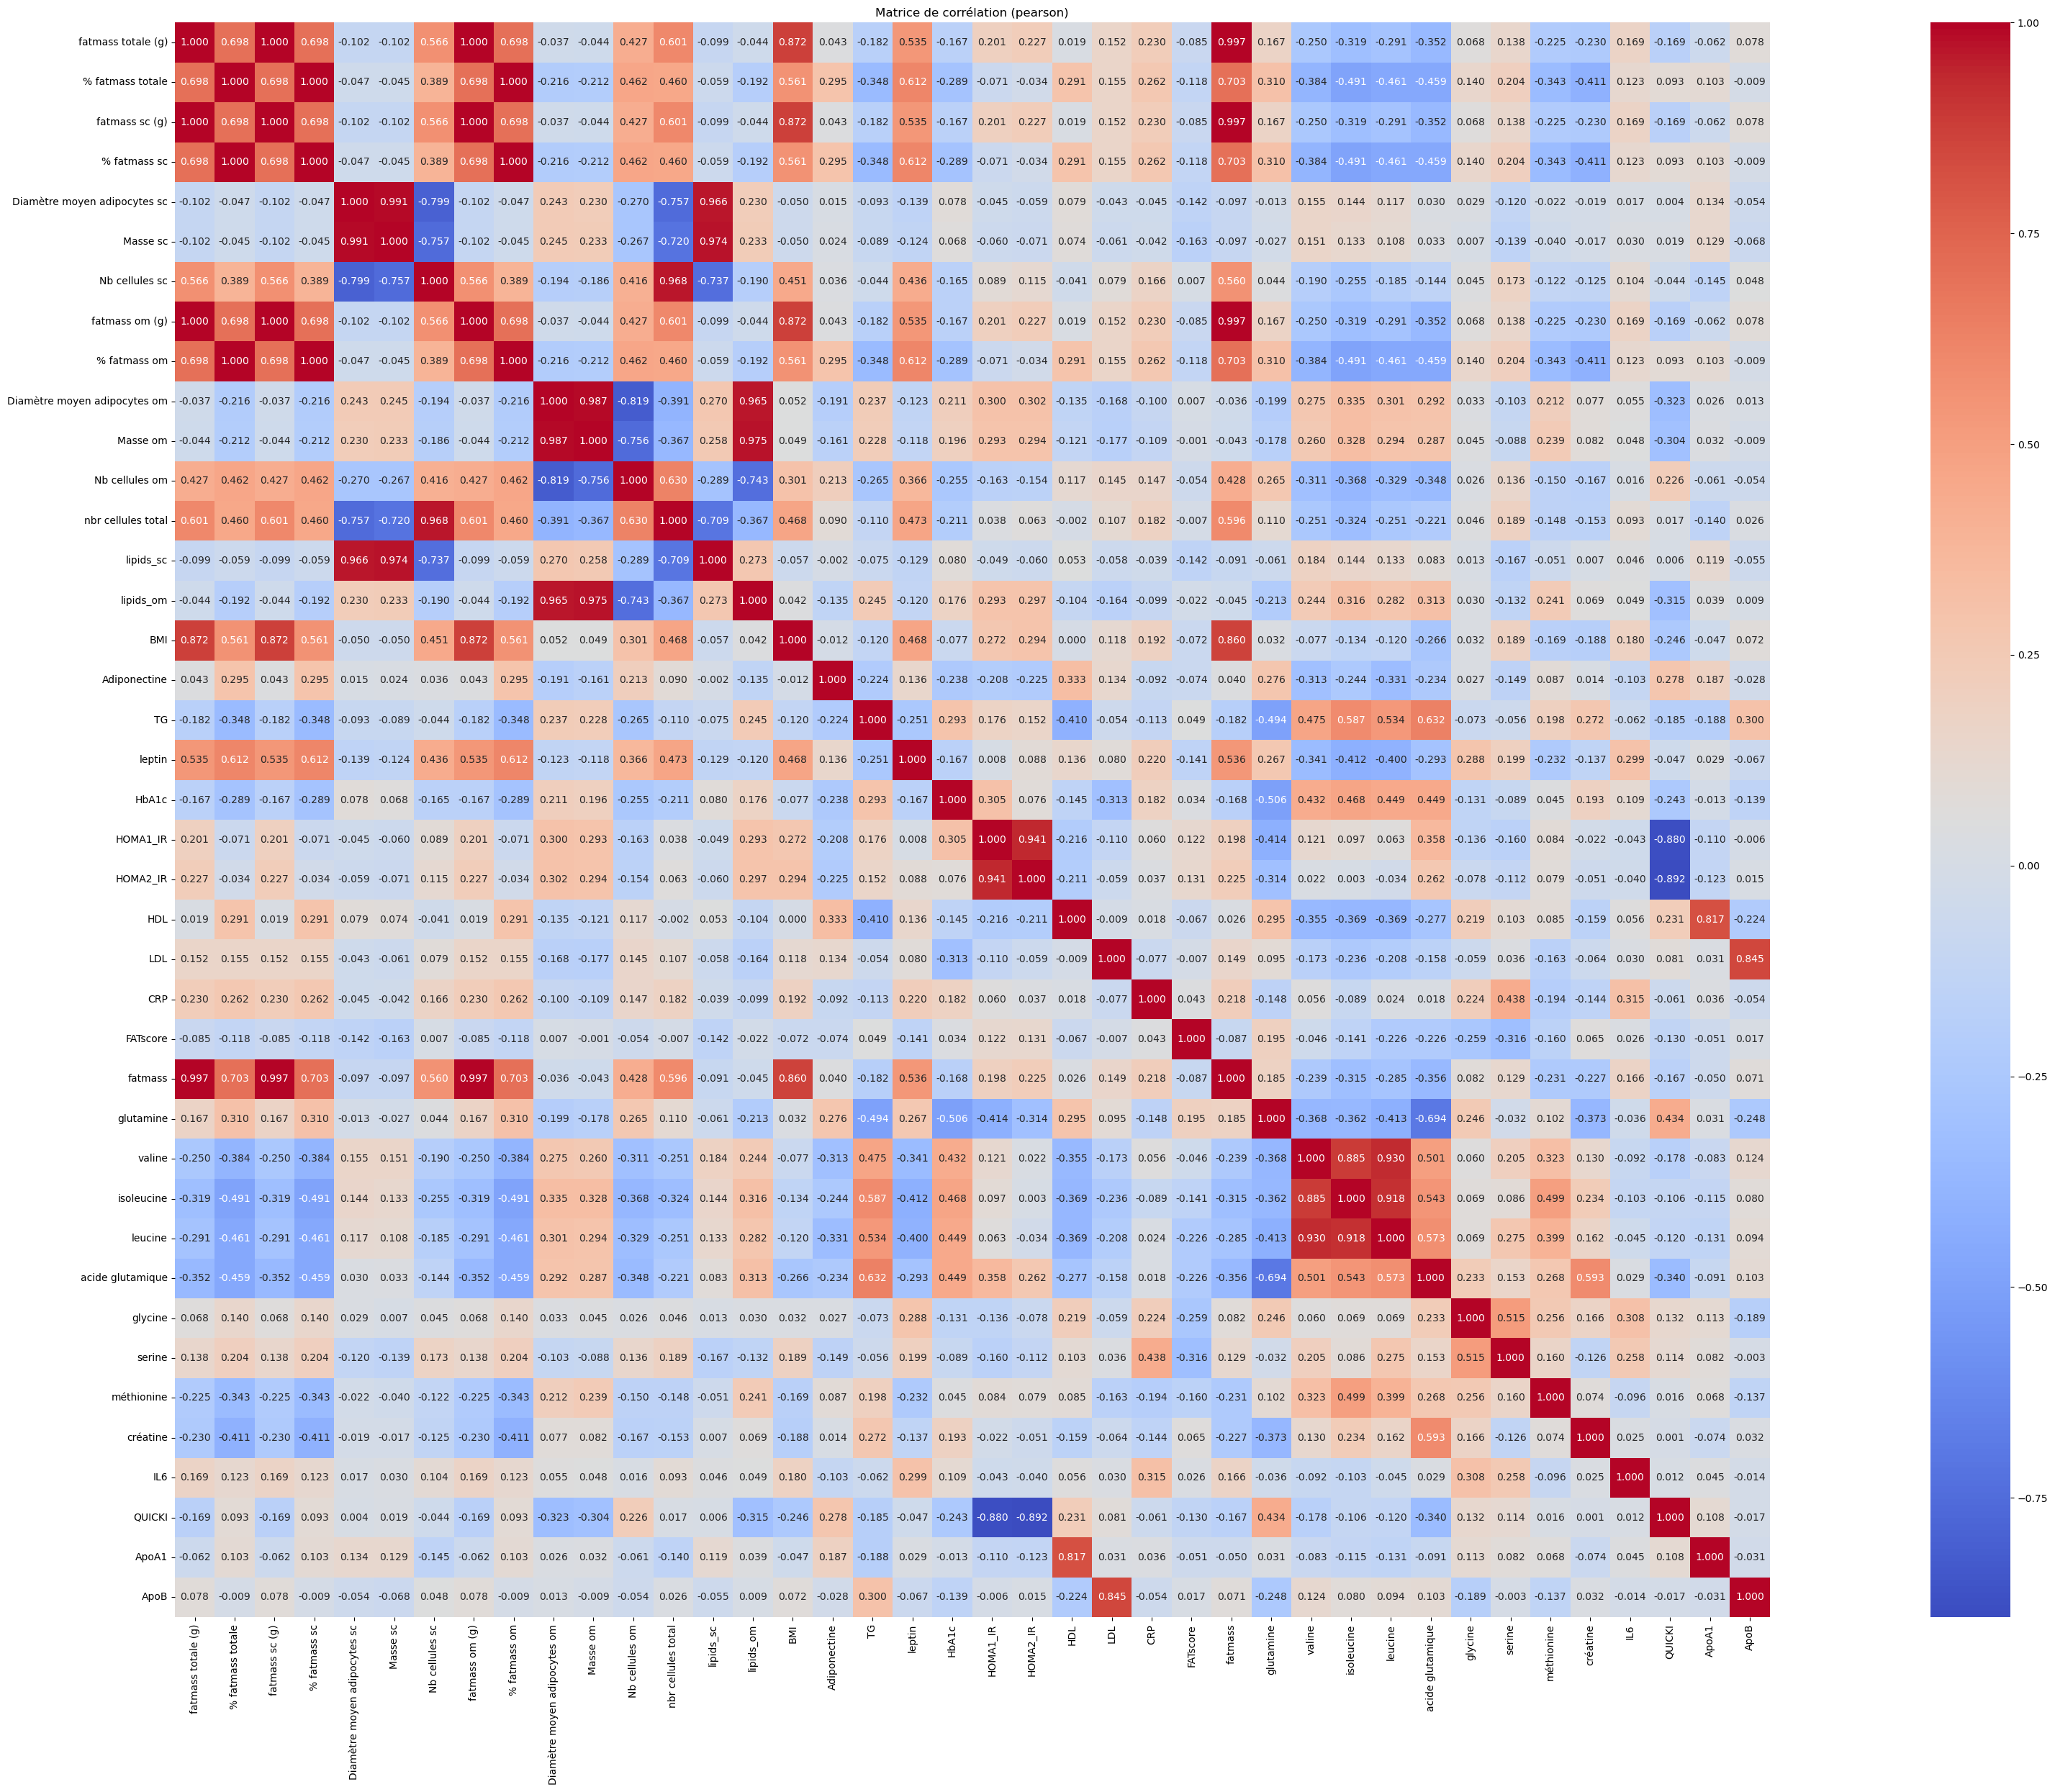

In [347]:

corr = analyse.corr(method='pearson')

plt.figure(figsize=(45, 25))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f", square=True)
plt.title("Matrice de corrélation (pearson)")
plt.tight_layout()
plt.show()

### **CLUSTERING ET NOMBRE D'ADIPOCYTES** ###

In [348]:

# clustering_matrix = pd.concat([variables_m["LDL"],variables_m["CRP"],variables_m["HOMA1_IR"],analyse["Nb cellules om"]/10**11,analyse["Nb cellules sc"]/10**11,analyse["nbr cellules total"]/10**11],axis = 1).dropna()
# clustering_matrix = pd.concat([variables_m["BMI"],variables_m["leptin"],analyse["Nb cellules om"]/1e10,analyse["Nb cellules sc"]/1e10,analyse["nbr cellules total"]/1e10],axis = 1).dropna()
# clustering_matrix = pd.concat([variables_m["BMI"],variables_m["leptin"],analyseHOMMES["Nb cellules om"],analyseHOMMES["Nb cellules sc"],analyseHOMMES["nbr cellules total"]],axis = 1).dropna()
# clustering_matrix = pd.concat([variables_m["BMI"],variables_m["leptin"],variables_m["HbA1c"],variables_m["TG"],analyse["lipids_sc"],analyse["lipids_om"]],axis = 1).dropna()
# clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["HOMA1_IR"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["HDL"],variables_m["LDL"],variables_m["FATscore"],variables_m["IL6"],variables_m["QUICKI"],variables_m["ApoA1"],variables_m["ApoB"]],axis = 1).dropna() # pas significatif
# clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["HOMA1_IR"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["HDL"],variables_m["LDL"],variables_m["IL6"],variables_m["QUICKI"],variables_m["ApoA1"],variables_m["ApoB"]],axis = 1).dropna() # significatif à 0.00587
# clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["HOMA1_IR"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["LDL"],variables_m["IL6"],variables_m["QUICKI"],variables_m["ApoB"]],axis = 1).dropna() #significatif à 0.006017
clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["HOMA1_IR"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["LDL"],variables_m["IL6"],variables_m["QUICKI"]],axis = 1).dropna() #significatif à 0.00232
# clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["HOMA1_IR"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["LDL"],variables_m["IL6"]],axis = 1).dropna() # significatif à 0.00232
# clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["HOMA1_IR"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["LDL"],variables_m["IL6"],variables_m["ApoA1"]],axis = 1).dropna() # significatif à 0.0046
# clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["LDL"],variables_m["IL6"]],axis = 1).dropna() #significatif à 0.006288
# clustering_matrix = pd.concat([variables_m["HbA1c"],variables_m["TG"],variables_m["CRP"],variables_m["créatine"],variables_m["Adiponectine"],variables_m["IL6"]],axis = 1).dropna() #significatif à 0.01057

clustering_matrix

,HbA1C,Trigly,CRP,HOMA1_IR,Creat_P,Adiponectine,LDL,IL6,QUICKI
N° patient,,,,,,,,,
patient 1,7.70e+00,1.99e+00,7.93e+00,1.23e+01,6.80e+01,4.63e+00,2.59e+00,5.16e+00,1.18e-01
patient 2,6.30e+00,6.70e-01,6.40e+00,6.57e+00,7.20e+01,5.99e+00,1.80e+00,2.63e+00,1.27e-01
patient 3,6.80e+00,1.28e+00,8.40e+00,1.18e+01,6.70e+01,3.00e+00,2.76e+00,5.60e+00,1.18e-01
patient 4,5.80e+00,1.44e+00,3.30e+00,2.58e+00,9.10e+01,1.05e+01,2.78e+00,4.56e+00,1.44e-01
patient 5,6.30e+00,9.60e-01,2.10e+01,7.65e+00,6.60e+01,3.10e+00,1.45e+00,5.94e+00,1.24e-01
...,...,...,...,...,...,...,...,...,...
patient 215,5.50e+00,1.52e+00,3.47e+00,6.63e+00,7.20e+01,5.20e+00,4.17e+00,4.40e+00,1.27e-01
patient 216,5.10e+00,1.89e+00,3.85e+00,9.22e+00,8.40e+01,5.40e+00,2.95e+00,4.00e+00,1.22e-01
patient 217,5.70e+00,9.80e-01,7.90e-01,5.29e+00,7.10e+01,2.60e+00,1.31e+00,2.80e+00,1.30e-01


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


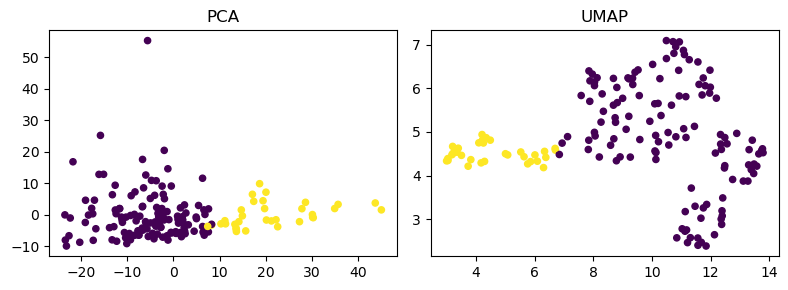

les loadings de la PCA sont :
         PC1       PC2
0  4.76e-03  4.76e-02
1  1.01e-02 -1.12e-02
2 -1.33e-01  9.79e-01
3 -8.14e-03  1.25e-02
4  9.91e-01  1.33e-01
5 -4.16e-03 -3.71e-02
6 -4.06e-03 -1.47e-02
7 -1.58e-02  1.37e-01
8  2.62e-05 -5.30e-05

les components de la PCA sont :
           PC1       PC2
0   -2.24e+00  7.46e-03
1    1.99e+00 -1.47e+00
2   -3.30e+00  4.13e-01
3    2.12e+01 -1.98e+00
4   -5.93e+00  1.26e+01
..        ...       ...
153  2.35e+00 -4.15e+00
154  1.42e+01 -2.21e+00
155  1.77e+00 -6.99e+00
156  5.34e-01 -5.40e+00
157  1.71e+01  6.48e+00

[158 rows x 2 columns]


In [349]:

# clustering spectral
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')   #clustering spectral avec 2 clusters       
labels_clustering = model.fit_predict(clustering_matrix) #assigne les clusters (0 à n clusters) 

#PCA et UMAP 
pca = PCA(n_components=2)
frequences_pca = pca.fit_transform(clustering_matrix)
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
frequences_umap = reducer.fit_transform(clustering_matrix)

#plot 
plt.subplots(1,2,figsize=(8,3))

plt.subplot(1,2,1)
plt.scatter(frequences_pca[:, 0], frequences_pca[:, 1], c=labels_clustering, cmap='viridis', s=20) 
plt.title("PCA")

plt.subplot(1,2,2)
plt.scatter(frequences_umap[:, 0], frequences_umap[:, 1],c = labels_clustering,s=20)
plt.title("UMAP")

plt.tight_layout()
plt.show()



components = pd.DataFrame(frequences_pca, columns=["PC1", "PC2"])
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"])


print('les loadings de la PCA sont :\n',loadings)
print('\nles components de la PCA sont :\n',components)


In [350]:
labels_clustering = pd.DataFrame(labels_clustering,columns=["labels clustering"],index=[x for x in clustering_matrix.index])

analyse_labels = pd.concat([analyse,labels_clustering],axis=1)
analyse_labels = analyse_labels.dropna(subset=["labels clustering"])
analyse_labels


for var in variables_m.keys():
    print(f"mean {var} cluster 1 : ", np.mean(analyse_labels[var][analyse_labels["labels clustering"] == 1]))
    print(f"mean {var} cluster 2 : ", np.mean(analyse_labels[var][analyse_labels["labels clustering"] == 0]), "\n")

mean BMI cluster 1 :  42.28190909090909
mean BMI cluster 2 :  47.220544000000004 

mean Adiponectine cluster 1 :  4.684545454545455
mean Adiponectine cluster 2 :  5.23088 

mean TG cluster 1 :  2.0778787878787877
mean TG cluster 2 :  1.38504 

mean leptin cluster 1 :  37.415151515151514
mean leptin cluster 2 :  59.90408 

mean HbA1c cluster 1 :  6.2
mean HbA1c cluster 2 :  6.074400000000001 

mean HOMA1_IR cluster 1 :  5.020123905727273
mean HOMA1_IR cluster 2 :  5.446082328968001 

mean HOMA2_IR cluster 1 :  2.484242424242424
mean HOMA2_IR cluster 2 :  2.7216 

mean HDL cluster 1 :  0.9924242424242424
mean HDL cluster 2 :  1.20296 

mean LDL cluster 1 :  2.9224793388484844
mean LDL cluster 2 :  2.9860363636320004 

mean CRP cluster 1 :  5.145757575757575
mean CRP cluster 2 :  8.68968 

mean FATscore cluster 1 :  1.4615384615384615
mean FATscore cluster 2 :  1.130952380952381 

mean fatmass cluster 1 :  52.30834552500001
mean fatmass cluster 2 :  62.88357958655463 

mean glutamine clus

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


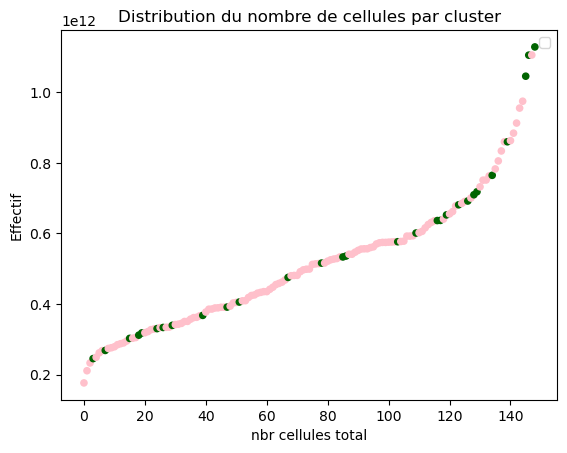

In [351]:
# Données
liste = ["fatmass totale (g)","nbr cellules total","lipids_sc","lipids_om"]
var = "nbr cellules total"

if var == "nbr cellules total" : 
    analyse_labels[var] = analyse_labels[var].where(analyse_labels[var]<1.2e12)

analyse_labels.dropna(subset=[var])



# Couleurs personnalisées
colors = ['pink', 'darkgreen', 'green']  # adapter si > 3 clusters

labels_nbr = analyse_labels.sort_values(by=var, ascending=True)
clusters = analyse_labels["labels clustering"]
plt.figure()
plt.scatter(
    x=range(len(labels_nbr)),
    y=labels_nbr[var],
    c=clusters.map(dict(enumerate(colors))),
    s=20)

# Mise en forme
plt.legend()
plt.xlabel(var)
plt.ylabel("Effectif")
plt.title("Distribution du nombre de cellules par cluster")
plt.savefig("/Users/elodiehusson/Desktop/courbe.pdf")
plt.show()

la p value est NON significative de nan


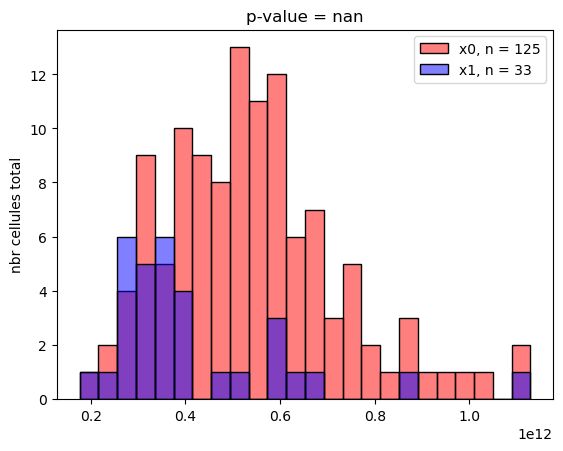

In [352]:
x = analyse_labels[var].where(analyse_labels[var]<1.2e12)

binning = np.linspace(min(x),max(x),25)

x0 = x.values[np.where(clusters.values==0)]
h0,b0 = np.histogram(x0,bins=binning)

x1 = x.values[np.where(clusters.values==1)]
h1,b1 = np.histogram(x1,bins=binning)

x0 = np.array(x0, dtype='float64')
x1 = np.array(x1, dtype='float64')

t_stat, pval = ttest_ind(x0, x1,equal_var=False)
if pval <0.05 : 
    print("la p value est SIGNIFICATIVE de ",pval)
else :
    print("la p value est NON significative de",pval)

plt.figure()
sns.histplot(x0,bins=binning,color='red',alpha=0.5,label=f"x0, n = {len(x0)}")
sns.histplot(x1,bins=binning,color='blue',alpha=0.5,label=f"x1, n = {len(x1)}")
plt.ylabel(var)
plt.legend()
plt.title( f'p-value = {pval:.4f}')
plt.savefig("/Users/elodiehusson/Desktop/histo.pdf")
plt.show()

# χ² sur groupes hyperplasiques et hypertrophiques

In [358]:
hypertrophie_index = analyse["nbr cellules total"].where(analyse["nbr cellules total"]<0.5191951659905382e12).dropna().index
hyperplasie_index = analyse["nbr cellules total"].where(analyse["nbr cellules total"]>0.5191951659905382e12).dropna().index

hypertrophie_patients = pd.DataFrame(analyse["nbr cellules total"].dropna())
hyperplasie_patients = pd.DataFrame(analyse["nbr cellules total"].dropna())

hypertrophie_patients = hypertrophie_patients.T
hyperplasie_patients = hyperplasie_patients.T

for patient in hypertrophie_index : 
    hyperplasie_patients=hyperplasie_patients.drop(columns=patient)

for patient in hyperplasie_index : 
    hypertrophie_patients=hypertrophie_patients.drop(columns=patient)

hypertrophie_patients = hypertrophie_patients.T
hyperplasie_patients = hyperplasie_patients.T

In [360]:

diabete_status = variables_métabo["Diabetes_status"]
diabete = []



hypertrophie = pd.DataFrame("hypertrophie", index=hypertrophie_index,  columns=["type_cellulaire"])
hyperplasie = pd.DataFrame("hyperplasie", index=hyperplasie_index,  columns=["type_cellulaire"])

x = pd.concat([hypertrophie, hyperplasie],axis=0)

type_cellulaire = []
for patient in range(1, 225):
    patient_id = f"patient {patient}"
    if patient_id in x.index:
        type_cellulaire.append(x.loc[patient_id, "type_cellulaire"])
    else:
        type_cellulaire.append(pd.NA)  # ← valeur manquante reconnue par pandas

diabete_status

df_chi2 = pd.DataFrame ({
    "type de diabète" : diabete_status.values,
    "type_cellulaire" : type_cellulaire,
})

diabete_status

N° patient
patient 1                diabetes
patient 2      glucose_intolerant
patient 3                diabetes
patient 4      glucose_intolerant
patient 5      glucose_intolerant
                      ...        
patient 220                normal
patient 221              diabetes
patient 222    glucose_intolerant
patient 223              diabetes
patient 224              diabetes
Name: Diabetes_status, Length: 224, dtype: object

Table observée :
type_cellulaire     hyperplasie  hypertrophie
type de diabète                              
diabetes                     28            55
glucose_intolerant           43            39
normal                       24            26

Table attendue si indépendance :
type_cellulaire     hyperplasie  hypertrophie
type de diabète                              
diabetes               3.67e+01      4.63e+01
glucose_intolerant     3.62e+01      4.58e+01
normal                 2.21e+01      2.79e+01

Statistique du test χ² = 6.235588
p-value = 0.0443


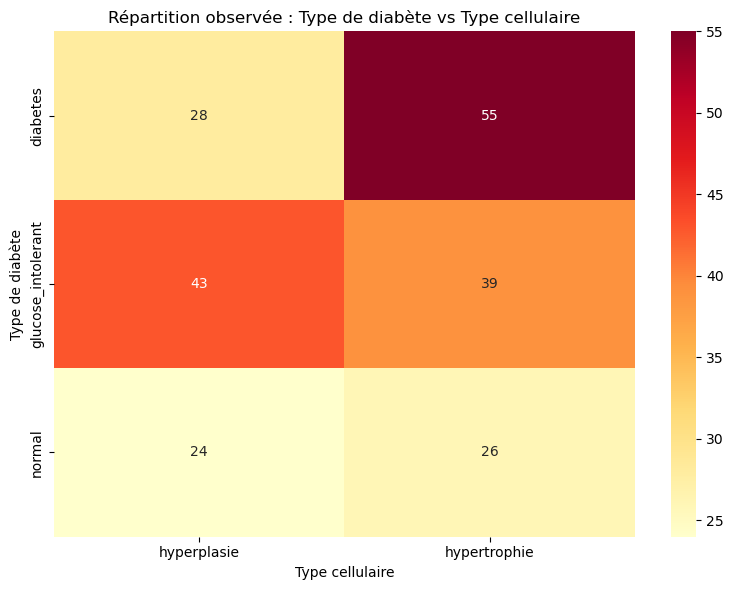

In [361]:
table = pd.crosstab(df_chi2["type de diabète"], df_chi2["type_cellulaire"])

chi2, p, dof, expected = chi2_contingency(table)

print("Table observée :")
print(table)
print("\nTable attendue si indépendance :")
print(pd.DataFrame(expected, index=table.index, columns=table.columns))

print(f"\nStatistique du test χ² = {chi2:.6f}")
print(f"p-value = {p:.4f}")

# Création de la heatmap à partir de la table observée
plt.figure(figsize=(8, 6))
sns.heatmap(table, annot=True, fmt='d', cmap='YlOrRd', cbar=True)

plt.title("Répartition observée : Type de diabète vs Type cellulaire")
plt.xlabel("Type cellulaire")
plt.ylabel("Type de diabète")
plt.tight_layout()
plt.show()